In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, gc, ipaddress, lime, lime.lime_tabular, itertools, warnings
import datetime as dt
import seaborn as sns
import matplotlib.gridspec as gridspec
import random as rnd
import plotly.graph_objs as go
warnings.filterwarnings(action='once')
from pandas.tools.plotting import scatter_matrix
from functools import reduce
from numpy import genfromtxt
from scipy import linalg
from scipy.stats import multivariate_normal
from sklearn import preprocessing, mixture
from sklearn.metrics import classification_report, average_precision_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning:

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88

/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192



In [2]:
def data_cleasing(df):
    # data cleasing, feature engineering and save clean data into pickles
    
    print('### Data Cleasing and Feature Engineering')
    df.head()
    le = preprocessing.LabelEncoder()
    
    # [Protocol] - Discard ipv6-icmp and categorize
    df['Proto'] = df['Proto'].fillna('-')
    df['Proto'] = le.fit_transform(df['Proto'])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    # [Label] - Categorize 
    anomalies = df.Label.str.contains('Botnet')
    normal = np.invert(anomalies);
    df.loc[anomalies, 'Label'] = np.uint8(1)
    df.loc[normal, 'Label'] = np.uint8(0)
    df['Label'] = pd.to_numeric(df['Label'])

    # [Dport] - replace NaN with 0 port number
    df['Dport'] = df['Dport'].fillna('0')
    df['Dport'] = df['Dport'].apply(lambda x: int(x,0))

    # [sport] - replace NaN with 0 port number
    try:
        df['Sport'] = df['Sport'].fillna('0')
        df['Sport'] = df['Sport'].str.replace('.*x+.*', '0')
        df['Sport'] = df['Sport'].apply(lambda x: int(x,0))
    except:                        
        print("### data_cleasing: Unexpected error:", sys.exc_info()[0])

    # [sTos] - replace NaN with "10" and convert to int
    df['sTos'] = df['sTos'].fillna('10')
    df['sTos'] = df['sTos'].astype(int)

    # [dTos] - replace NaN with "10" and convert to int
    df['dTos'] = df['dTos'].fillna('10')
    df['dTos'] = df['dTos'].astype(int)

    # [State] - replace NaN with "-" and categorize
    df['State'] = df['State'].fillna('-')
    df['State'] = le.fit_transform(df['State'])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    # [Dir] - replace NaN with "-" and categorize 
    df['Dir'] = df['Dir'].fillna('-')
    df['Dir'] = le.fit_transform(df['Dir'])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    # [SrcAddr] Extract subnet features and categorize
    df['SrcAddr'] = df['SrcAddr'].fillna('0.0.0.0')
    
    # [DstAddr] Extract subnet features
    df['DstAddr'] = df['DstAddr'].fillna('0.0.0.0')
    
    # [StartTime] - Parse to datatime, reindex based on StartTime, but first drop the ns off the time stamps
    df['StartTime'] = df['StartTime'].apply(lambda x: x[:19])
    df['StartTime'] = pd.to_datetime(df['StartTime'])
    df = df.set_index('StartTime')
    
    gc.collect()
    
    return df


def classify_ip(ip):
    '''
    str ip - ip address string to attempt to classify. treat ipv6 addresses as N/A
    '''
    try: 
        ip_addr = ipaddress.ip_address(ip)
        if isinstance(ip_addr, ipaddress.IPv6Address):
            return 'ipv6'
        elif isinstance(ip_addr, ipaddress.IPv4Address):
            # split on .
            octs = ip_addr.exploded.split('.')
            if 0 < int(octs[0]) < 127: return 'A'
            elif 127 < int(octs[0]) < 192: return 'B'
            elif 191 < int(octs[0]) < 224: return 'C'
            else: return 'N/A'
    except ValueError:
        return 'N/A'
            
        
def avg_duration(x):
    return np.average(x)
        
    
def n_dports_gt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a,b: a+b if b>1024 else a),x)
n_dports_gt1024.__name__ = 'n_dports>1024'


def n_dports_lt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a,b: a+b if b<1024 else a),x)
n_dports_lt1024.__name__ = 'n_dports<1024'


def n_sports_gt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a,b: a+b if b>1024 else a),x)
n_sports_gt1024.__name__ = 'n_sports>1024'


def n_sports_lt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a,b: a+b if b<1024 else a),x)
n_sports_lt1024.__name__ = 'n_sports<1024'


def label_atk_v_norm(x):
    for l in x:
        if l == 1: return 1
    return 0
label_atk_v_norm.__name__ = 'label'


def background_flow_count(x):
    count = 0
    for l in x:
        if l == 0: count += 1
    return count


def normal_flow_count(x):
    if x.size == 0: return 0
    count = 0
    for l in x:
        if l == 0: count += 1
    return count


def n_conn(x):
    return x.size


def n_tcp(x):
    count = 0
    for p in x: 
        if p == 10: count += 1 # tcp == 10
    return count


def n_udp(x):
    count = 0
    for p in x: 
        if p == 11: count += 1 # udp == 11
    return count


def n_icmp(x):
    count = 0
    for p in x: 
        if p == 1: count += 1 # icmp == 1
    return count


def n_s_a_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'A': count += 1
    return count


def n_d_a_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'A': count += 1
    return count


def n_s_b_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'B': count += 1
    return count


def n_d_b_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'A': count += 1
    return count


def n_s_c_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'C': count += 1
    return count


def n_d_c_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'C': count += 1
    return count


def n_s_na_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'N/A': count += 1
    return count


def n_d_na_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'N/A': count += 1
    return count


def n_ipv6(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'ipv6': count += 1
    return count

In [3]:
%%time
# features
column_types = {
            'StartTime': 'str',
            'Dur': 'float32',
            'Proto': 'str',
            'SrcAddr': 'str',
            'Sport': 'str',
            'Dir': 'str',
            'DstAddr': 'str',
            'Dport': 'str',
            'State': 'str',
            'sTos': 'float16',
            'dTos': 'float16',
            'TotPkts': 'uint32',
            'TotBytes': 'uint32',
            'SrcBytes': 'uint32',
            'Label': 'str'}

raw_df = pd.read_csv('/media/thiago/ubuntu/datasets/network/stratosphere_botnet_2011/ctu_13/raw_fast/capture20110816-2.binetflow', header = 0, dtype=column_types)
df = data_cleasing(raw_df)

### Data Cleasing and Feature Engineering
CPU times: user 1.41 s, sys: 31.3 ms, total: 1.44 s
Wall time: 1.44 s


In [4]:
# data overview
print("\nData Shape: ", df.shape)
print("\nData Types: ", df.dtypes)
df.head()


Data Shape:  (114077, 14)

Data Types:  Dur         float32
Proto         int64
SrcAddr      object
Sport         int64
Dir           int64
DstAddr      object
Dport         int64
State         int64
sTos          int64
dTos          int64
TotPkts      uint32
TotBytes     uint32
SrcBytes     uint32
Label         int64
dtype: object


,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
StartTime,,,,,,,,,,,,,,
2011-08-16 13:52:03,2.925519,9,147.32.86.58,3184,0,77.75.73.9,80,120,0,0,3,182,122,0
2011-08-16 13:52:17,1.046300,9,147.32.3.51,4420,0,147.32.84.46,10010,123,0,0,4,244,124,0
2011-08-16 13:52:32,2.898050,9,147.32.86.58,3246,0,77.75.73.9,80,120,0,0,3,182,122,0
2011-08-16 13:58:28,8.979935,9,212.95.7.124,8811,0,147.32.84.229,13363,108,0,0,7,508,208,0
2011-08-16 13:58:55,5.832105,9,109.166.138.80,58325,0,147.32.84.229,13363,108,0,0,8,538,294,0


In [5]:
# number of repeated values
print("\nProto:\n", df['Proto'].value_counts())
print("\nSrcAddr:\n", df['SrcAddr'].value_counts())
print("\nDstAddr:\n", df['DstAddr'].value_counts())
print("\nDport:\n", df['Dport'].value_counts())
print("\nState:\n", df['State'].value_counts())
print("\nsTos:\n", df['sTos'].value_counts())
print("\ndTos:\n", df['dTos'].value_counts())
print("\nLabel:\n", df['Label'].value_counts())


Proto:
 10    89247
9     22889
1      1653
2       103
7        85
0        64
8        25
4         7
5         2
6         1
3         1
Name: Proto, dtype: int64

SrcAddr:
 147.32.84.138     19098
147.32.84.59      18873
147.32.84.229      8561
147.32.84.94       3663
147.32.85.7        3242
147.32.85.25       3039
147.32.86.20       1805
147.32.86.168      1739
147.32.85.34       1673
147.32.85.8        1610
147.32.86.134      1565
147.32.85.23        886
147.32.86.187       879
147.32.86.58        879
147.32.84.170       807
147.32.86.223       747
147.32.86.50        714
147.32.84.184       664
147.32.86.165       633
147.32.85.88        602
147.32.85.26        557
147.32.84.164       520
147.32.85.123       503
147.32.85.87        464
147.32.84.19        448
147.32.85.117       445
147.32.87.238       414
147.32.84.171       385
147.32.86.171       329
147.32.85.22        295
                  ...  
79.170.210.172        1
80.188.113.41         1
78.130.248.8          1
79.189

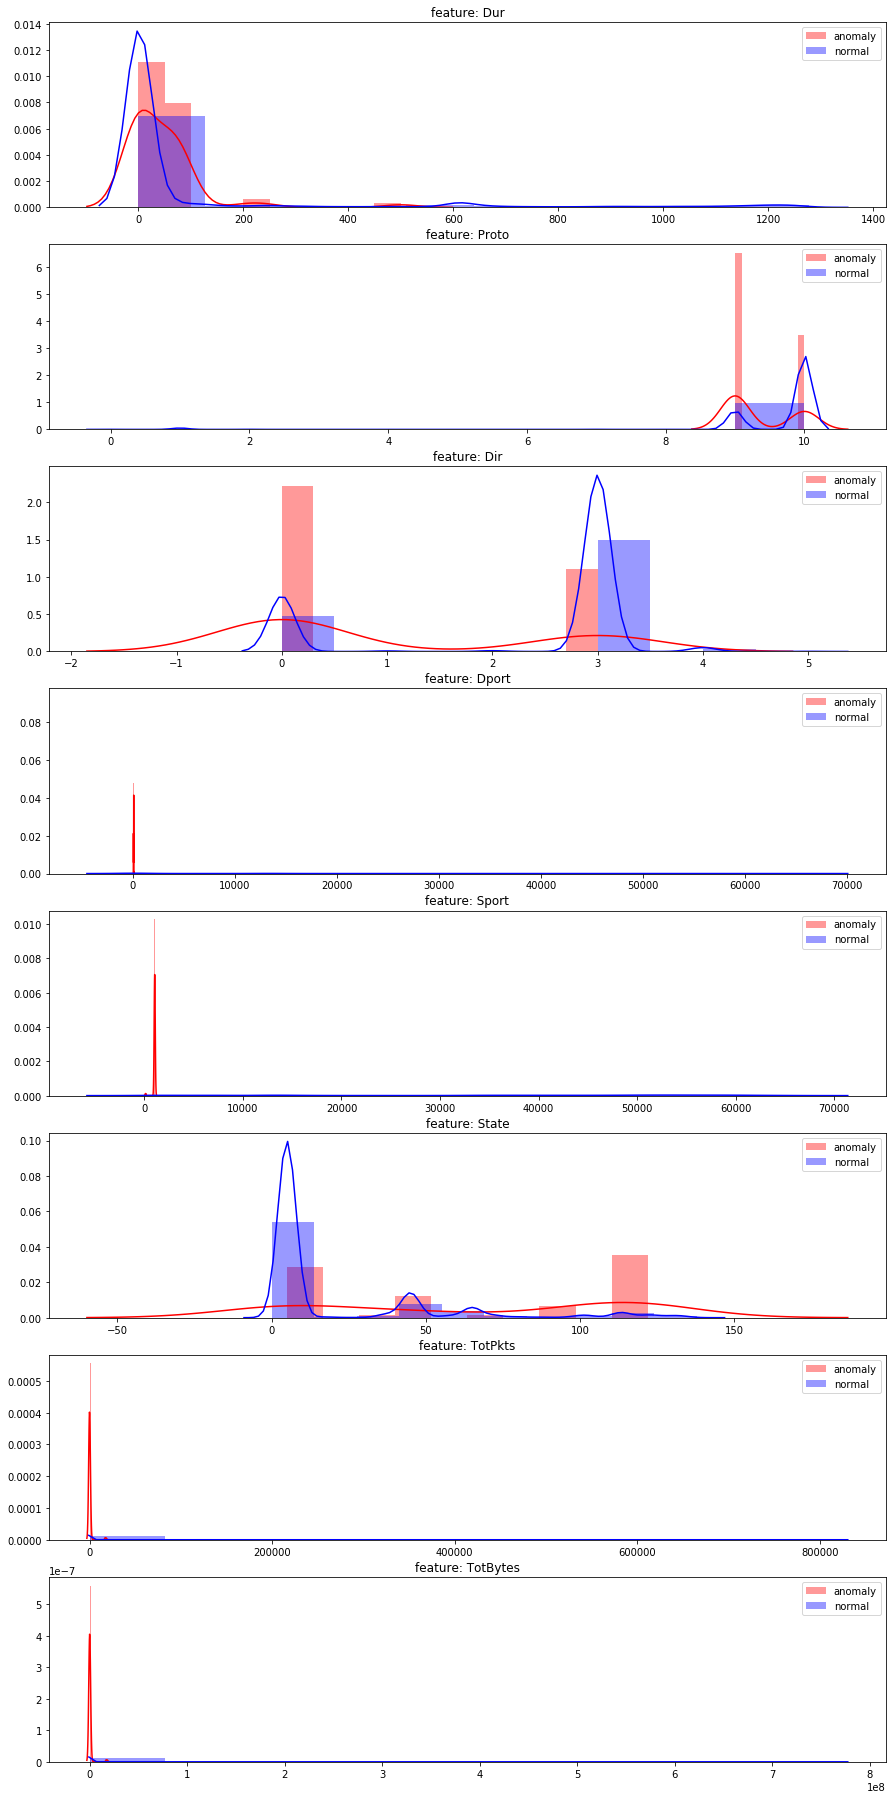

CPU times: user 6.57 s, sys: 22.5 ms, total: 6.59 s
Wall time: 6.59 s


In [6]:
%%time
v_features = [
    'Dur',
    'Proto',
    'Dir',
    'Dport',
    'Sport',
    'State',
    'TotPkts',
    'TotBytes'
#     'SrcBytes',
#     'SrcAddr0',
#     'DstAddr0',
#     'DstAddr1',
#     'DstAddr2',
#     'DstAddr3'
]

nplots=np.size(v_features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Label == 1], bins=10, label='anomaly', color='r')
    sns.distplot(df[cn][df.Label == 0], bins=10, label='normal', color='b')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
    plt.legend()
plt.savefig('results/figures/raw_distplot.png')
plt.show()

CPU times: user 2.37 s, sys: 3.84 ms, total: 2.38 s
Wall time: 2.37 s


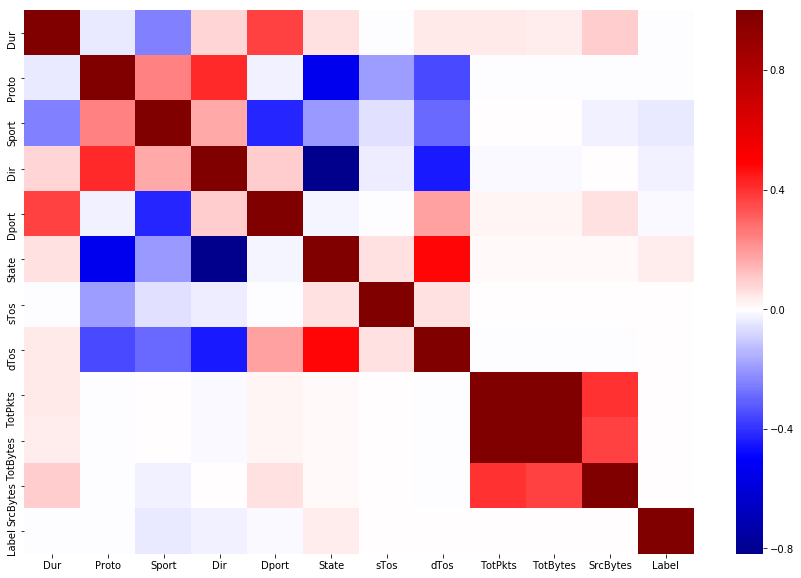

In [7]:
%%time
corr = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns_plot = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, ax=ax, center=0, cmap="seismic")
figure = sns_plot.get_figure()
figure.savefig('results/figures/raw_corr_heatmap.png', dpi=400)

CPU times: user 4.46 s, sys: 15.7 ms, total: 4.48 s
Wall time: 4.47 s


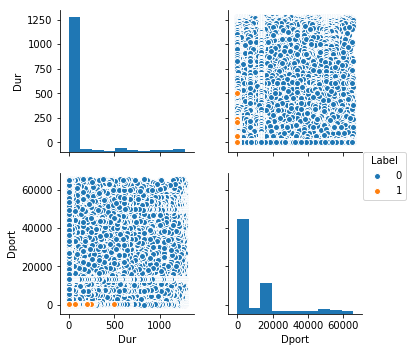

In [8]:
%%time
# drops N/A values
tmp_df = df.dropna()

# Create a scatter matrix of the aggregated dataframe
# Choose a few interesting features to pairplot based on the heat maps
plot_features = ['Dur','Dport']
sns_plot = sns.pairplot(tmp_df, vars=plot_features, hue='Label')
sns_plot.savefig("results/figures/raw_pairplot.png")

In [9]:
# The datastructure to hold our feature extraction functions, 
# which will get applied to each aggregation of the datasets.
extractors = {
    'Label'   : [label_atk_v_norm, background_flow_count, normal_flow_count, n_conn,],
    'Dport'   : [n_dports_gt1024, n_dports_lt1024],
    'Sport'   : [n_sports_gt1024, n_sports_lt1024,],
    'Dur'     : [avg_duration,],
    'SrcAddr' : [n_s_a_p_address, n_s_b_p_address, n_s_c_p_address, n_s_na_p_address,],
    'DstAddr' : [n_d_a_p_address, n_d_b_p_address, n_d_c_p_address, n_d_na_p_address,],
    'Proto'   : [n_tcp, n_icmp, n_udp,],
}
    
# resample grouped by 1 second bin. must have a datetime-like index.
r = df.resample('1S')
n_df = r.agg(extractors) ## aggretation by data and functions specified by extractors

n_df.columns = n_df.columns.droplevel(0) # get rid of the heirarchical columns
pd.options.display.max_columns = 99

In [10]:
print('New nData Types: ', n_df.dtypes)
n_df.head()

New nData Types:  avg_duration             float32
label                      int64
background_flow_count      int64
normal_flow_count          int64
n_conn                     int64
n_tcp                      int64
n_icmp                     int64
n_udp                      int64
n_d_a_p_address            int64
n_d_b_p_address            int64
n_d_c_p_address            int64
n_d_na_p_address           int64
n_dports>1024              int64
n_dports<1024              int64
n_s_a_p_address            int64
n_s_b_p_address            int64
n_s_c_p_address            int64
n_s_na_p_address           int64
n_sports>1024              int64
n_sports<1024              int64
dtype: object


,avg_duration,label,background_flow_count,normal_flow_count,n_conn,n_tcp,n_icmp,n_udp,n_d_a_p_address,n_d_b_p_address,n_d_c_p_address,n_d_na_p_address,n_dports>1024,n_dports<1024,n_s_a_p_address,n_s_b_p_address,n_s_c_p_address,n_s_na_p_address,n_sports>1024,n_sports<1024
StartTime,,,,,,,,,,,,,,,,,,,,
2011-08-16 13:51:24,647.540466,0,220,220,220,105,3,0,63,63,23,0,4037491,59878,50,155,15,0,6147403,11978
2011-08-16 13:51:25,485.618042,0,137,137,137,80,4,0,32,32,14,4,2163105,7685,30,90,16,1,3593062,4721
2011-08-16 13:51:26,373.078888,0,151,151,151,102,3,0,40,40,17,0,2138424,14221,32,114,5,0,4652485,9227
2011-08-16 13:51:27,641.157227,0,148,148,148,94,6,0,58,58,11,0,3308461,67872,28,112,8,0,3525198,4655
2011-08-16 13:51:28,679.089050,0,215,215,215,144,2,0,97,97,23,1,6243468,10595,32,169,13,1,4651207,55285


singular matrix


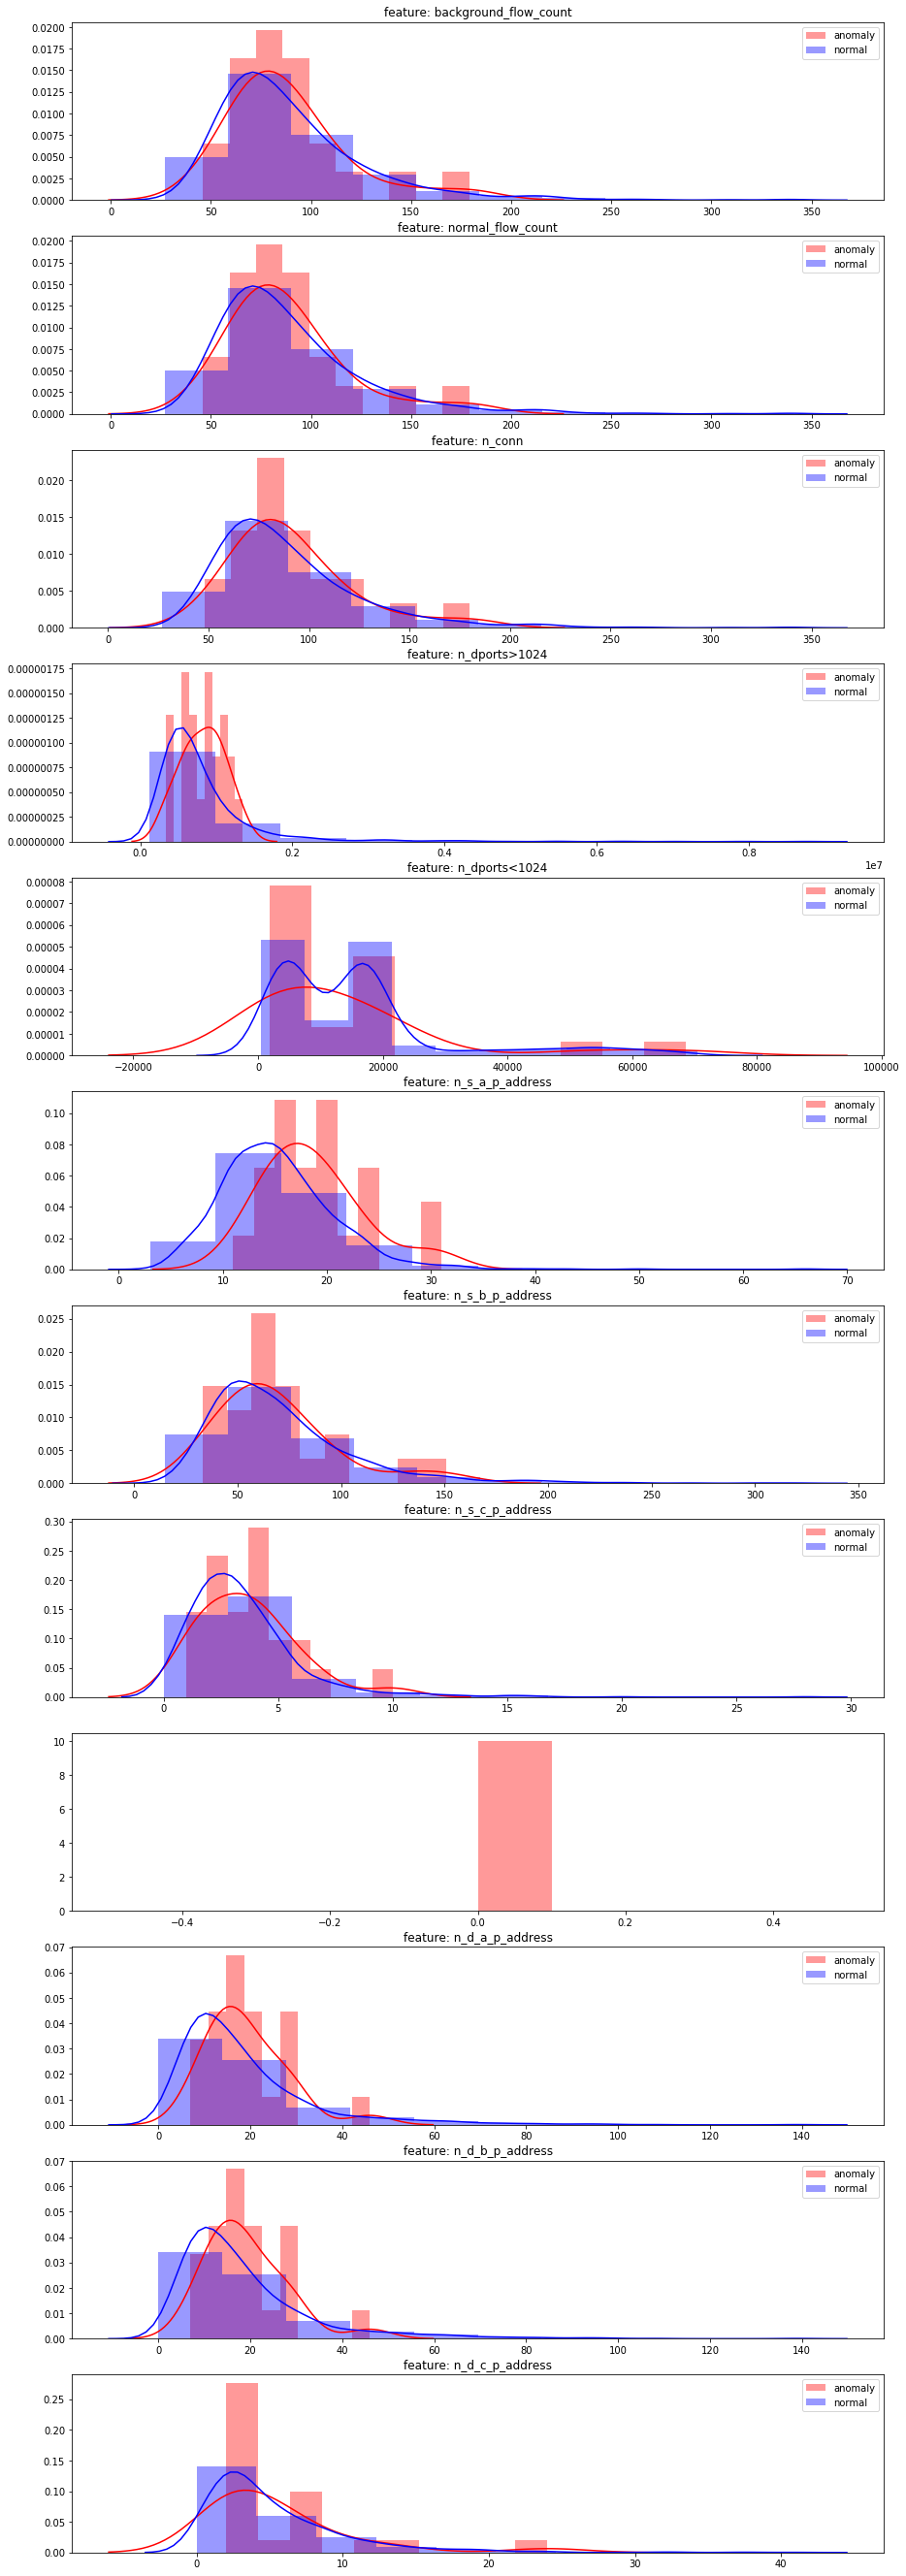

CPU times: user 4.85 s, sys: 68.1 ms, total: 4.92 s
Wall time: 4.92 s


In [11]:
%%time
n_features = ['background_flow_count','normal_flow_count','n_conn','n_dports>1024','n_dports<1024','n_s_a_p_address','n_s_b_p_address','n_s_c_p_address','n_s_na_p_address','n_d_a_p_address','n_d_b_p_address','n_d_c_p_address']
nplots=np.size(n_features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, cn in enumerate(n_df[n_features]):
    try:
        ax = plt.subplot(gs[i])
        sns.distplot(n_df[cn][n_df.label == 1], bins=10, label='anomaly', color='r')
        sns.distplot(n_df[cn][n_df.label == 0], bins=10, label='normal', color='b')
        ax.set_xlabel('')
        ax.set_title('feature: ' + str(cn))
        plt.legend()
    except Exception as e: 
        print(e)
plt.savefig('results/figures/sum_distplot.png')
plt.show()

CPU times: user 2.44 s, sys: 31.9 ms, total: 2.47 s
Wall time: 2.46 s


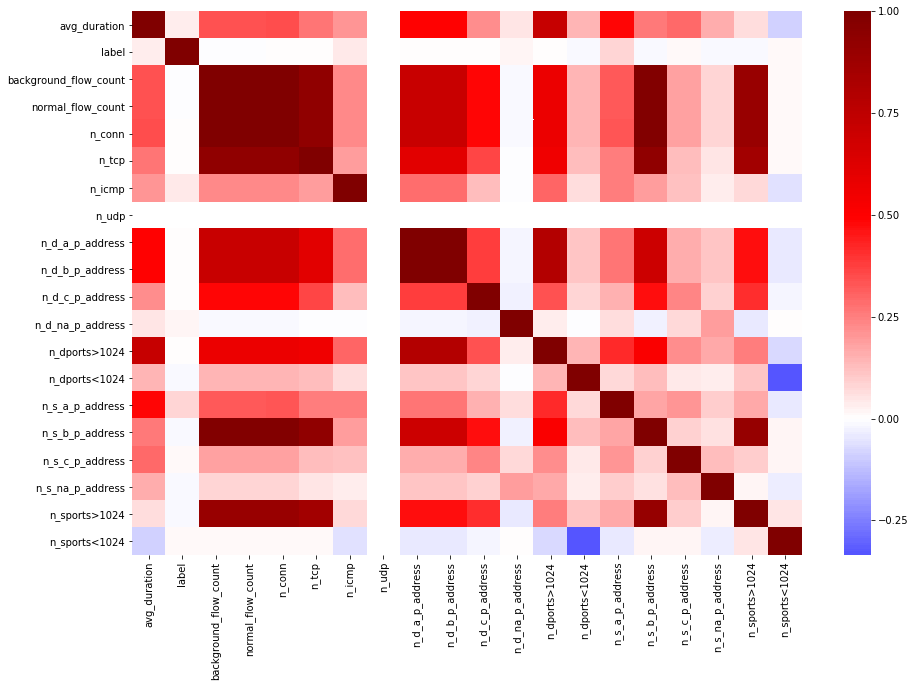

In [12]:
%%time
corr = n_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns_plot = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, ax=ax, center=0, cmap="seismic")
figure = sns_plot.get_figure()
figure.savefig('results/figures/sum_corr_heatmap.png', dpi=400)

CPU times: user 5.07 s, sys: 11.9 ms, total: 5.08 s
Wall time: 5.07 s


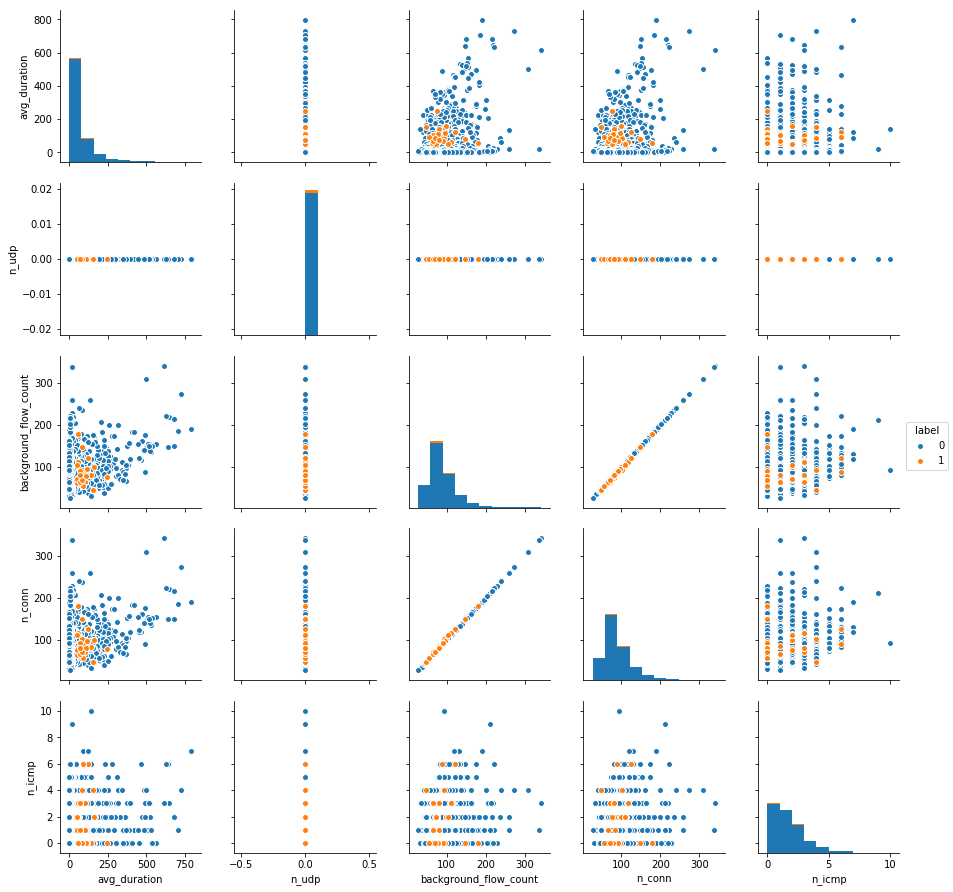

In [13]:
%%time
# drops N/A values
tmp_df = n_df.dropna()

# Create a scatter matrix of the aggregated dataframe
# choose a few interesting features to pairplot based on the heat maps
plot_features = ['avg_duration','n_udp','background_flow_count','n_conn','n_icmp']
sns_plot = sns.pairplot(tmp_df, vars=plot_features, hue='label')
sns_plot.savefig("results/figures/sum_pairplot.png")

CPU times: user 1.06 s, sys: 16 ms, total: 1.07 s
Wall time: 1.07 s


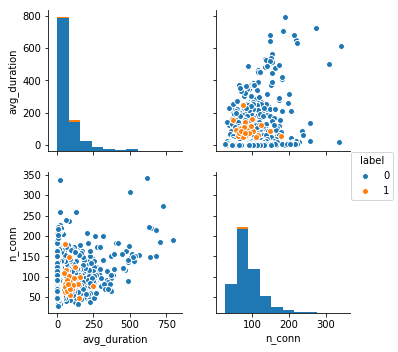

In [14]:
%%time
# drops N/A values
tmp_df = n_df.dropna()

# Create a scatter matrix of the aggregated dataframe
# choose a few interesting features to pairplot based on the heat maps
plot_features = ['avg_duration','n_conn']
sns_plot = sns.pairplot(tmp_df, vars=plot_features, hue='label')
sns_plot.savefig("results/figures/sum_pairplot.png")